In [ ]:
from starspot import Star as ST
from starspot import Spot as Spot

In [ ]:
st1 = ST(no_evolution=True)
st1.simulate_spots()

In [ ]:
time = st1.spot_dict['1']['time']
lat1 = np.degrees(st1.spot_dict['1']['latitude'])
lat2 = np.degrees(st1.spot_dict['2']['latitude'])

lon1 = np.degrees(st1.spot_dict['1']['longitude'])
lon2 = np.degrees(st1.spot_dict['2']['longitude'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
flataxs = axs.flatten()
flataxs[0].plot(time, lat1, 'b', label='Spot 1')
flataxs[0].plot(time, lat2, 'r', label='Spot 2')
flataxs[0].set_xlabel('Year')
flataxs[0].set_title('Latitude')
flataxs[0].legend()

flataxs[1].plot(time, lon1, 'b', label='Spot 1')
flataxs[1].plot(time, lon2, 'r', label='Spot 2')
flataxs[1].set_xlabel('Year')
flataxs[1].set_title('Longitude')
flataxs[1].legend()

fig.tight_layout()
plt.show()

In [ ]:
np.random.normal(st1.latitude_mean, st1.latitude_sigma)

In [ ]:
st1.latitude_mean

## How does beating modulate light curve?

In [134]:
from scipy.signal import savgol_filter as savgol

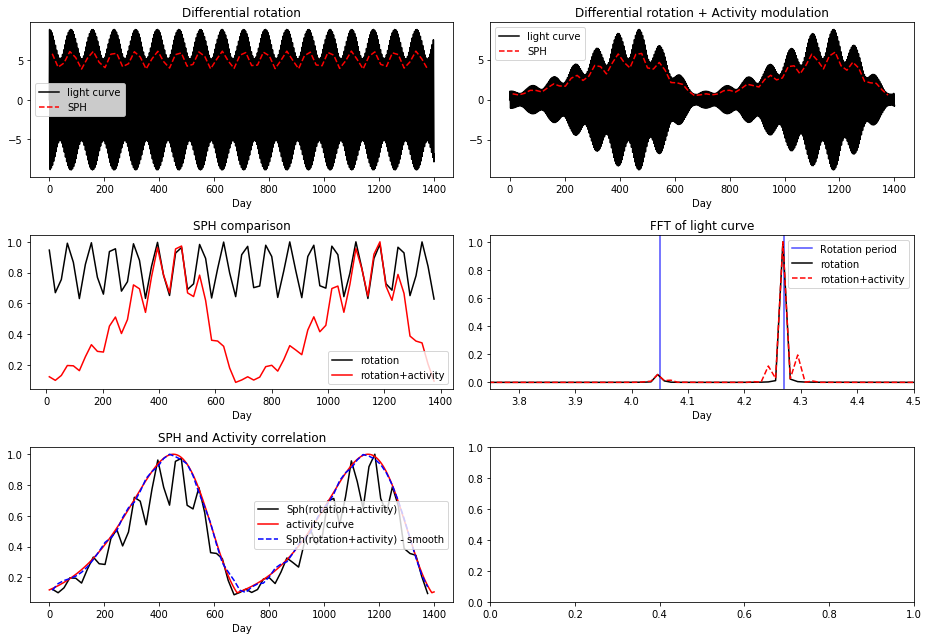

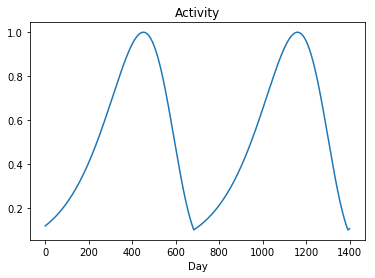

In [188]:
def compute_sph(sig, box_size):
    len_sig = len(sig)
    num_boxes = int(len_sig // box_size)
    sph = np.zeros(num_boxes, dtype=np.float64)
    t_sph = np.zeros(num_boxes, dtype=np.float64)
    start_idx = 0
    end_idx = 0
    for ib in range(num_boxes):
        end_idx = int(start_idx + box_size)
        sph[ib] = np.std(sig[start_idx:end_idx])
        t_sph[ib] = t[int((start_idx+end_idx)//2)]
        start_idx = int(end_idx)
    return sph, t_sph

def compute_fft(sig):
    fft_sig = np.fft.fft(sig)
    fft_freq = np.fft.fftfreq(len(sig), d=dt)
    mask_pos = fft_freq > 0
    fft_freq = fft_freq[mask_pos][1:]
    fft_sig = abs(fft_sig[mask_pos][1:])**2
    time_period = 1/fft_freq
    fft_sig /= fft_sig.max()
    return fft_sig, time_period, fft_freq

def gumbel(x, mu, beta, thintail=False):
    g = np.exp(-(x-mu)/beta) * np.exp(-np.exp(-(x-mu)/beta))/beta
    if thintail:
        return g[::-1]
    else:
        return g

def periodic_gumbel(x, mu, beta, thintail=False):
    g = gumbel(x, mu, beta, thintail=thintail)
    g_periodic = g*1.0
    gmax = g.max()
    g10 = gmax/10.
    sign_diff = np.sign(g-g10)
    g10_idxs = np.where((sign_diff[1:] * sign_diff[:-1]) < 0)[0]
    g10_idx_min = g10_idxs[0]
    g10_idx_max = g10_idxs[1]
    g_periodic[:g10_idx_min] = g[g10_idx_max-g10_idx_min:g10_idx_max]
    g_periodic[g10_idx_max:] = g[g10_idx_min:g10_idx_min+len(g)-g10_idx_max]
    # g_periodic = savgol(g_periodic, 3001, 5)
    return g_periodic/g_periodic.max()
    
    

t = np.linspace(0, 1400, 200000)
dt = t[1] - t[0]
T1, T2, T3 = 4.05, 4.27, 4.05
#T1, T2, T3 = 9.83, 10.2, 9.83
A1, A2, A3 = 1, 7, np.sqrt(3)/2
rot_period = max(T1, T2, T3)
prot_boxsize = 5*rot_period/dt
num_boxes = int(len(t)//prot_boxsize)

Tactivity2 = 1.6*365.25
signal1 = A1*np.sin(2*np.pi*t/T1)
signal2 = A2*np.sin(2*np.pi*t/T2)
signal3 = A3*np.sin(2*np.pi*t/T3)

#activity_modulation = np.sin(2*np.pi*t/Tactivity2 + 0.76)**2
activity_modulation = periodic_gumbel(t, 240, Tactivity2/4, thintail=True)
signal_total1 = (signal1 + signal2 + signal3)*1.0
signal_total2 = (signal1 + signal2 + signal3)*1.0*activity_modulation

fft_totsignal1, fft_periods1, freq1 = compute_fft(signal_total1)
fft_totsignal2, fft_periods2, freq2 = compute_fft(signal_total2)

sph1, t_sph1 = compute_sph(signal_total1, prot_boxsize)
sph2, t_sph2 = compute_sph(signal_total2, prot_boxsize)

dt_sph = prot_boxsize*dt
window = int(400/dt_sph)
if window%2 == 0: window += 1
sph2_smooth = savgol(sph2, window, 5)


fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13, 9))
flataxs = axs.flatten()
flataxs[0].plot(t, signal_total1, 'k', label='light curve')
flataxs[0].plot(t_sph1, sph1, '--r', label='SPH')
flataxs[0].legend()
flataxs[0].set_xlabel('Day')
flataxs[0].set_title('Differential rotation')

flataxs[1].plot(t, signal_total2, 'k', label='light curve')
flataxs[1].plot(t_sph2, sph2, '--r', label='SPH')
flataxs[1].legend()
flataxs[1].set_xlabel('Day')
flataxs[1].set_title('Differential rotation + Activity modulation')

flataxs[2].set_title('SPH comparison')
flataxs[2].plot(t_sph1, sph1/sph1.max(), 'k', label='rotation')
flataxs[2].plot(t_sph2, sph2/sph2.max(), 'r', label='rotation+activity')
flataxs[2].set_xlabel('Day')
flataxs[2].legend()

flataxs[3].axvline(x=T1, color='blue', alpha=0.7, label='Rotation period')
flataxs[3].axvline(x=T2, color='blue', alpha=0.7)
flataxs[3].plot(fft_periods1, fft_totsignal1, 'k', label='rotation')
flataxs[3].plot(fft_periods2, fft_totsignal2, '--r', label='rotation+activity')
flataxs[3].set_xlim([3.75, 4.5])
flataxs[3].set_xlabel('Day')
flataxs[3].set_title('FFT of light curve')
flataxs[3].legend()


flataxs[4].plot(t_sph2, sph2/sph2.max(), 'k', label='Sph(rotation+activity)')
flataxs[4].plot(t, activity_modulation, 'r', label='activity curve')
flataxs[4].plot(t_sph2, sph2_smooth/sph2_smooth.max(), '--b', label='Sph(rotation+activity) - smooth')
flataxs[4].set_xlabel('Day')
flataxs[4].set_title('SPH and Activity correlation')
flataxs[4].legend()

fig.tight_layout()
plt.show(fig)

plt.figure()
plt.plot(t, activity_modulation)
plt.title('Activity')
plt.xlabel('Day')
plt.show()



In [95]:
from scipy.signal import find_peaks

In [54]:
peak_freqs1 = freq1[find_peaks(fft_totsignal1)[0]]
peak_freqs2 = freq1[find_peaks(fft_totsignal2)[0]]

In [55]:
def get_central_freqs(freqs):
    cen_freqs = []
    len_freqs = len(freqs)
    for i in range(len_freqs):
        for ii in range(i+1, len_freqs):
            cen_freqs.append((freqs[i]+freqs[ii])/2)
    return np.array(cen_freqs)

In [56]:
cen_freqs1 = get_central_freqs(peak_freqs1)
cen_freqs2 = get_central_freqs(peak_freqs2)
print(cen_freqs1, peak_freqs1)

[0.2299977 0.2399976 0.2433309 0.2433309 0.2466642 0.2566641] [0.2266644 0.233331  0.2533308 0.2599974]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 2., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.1533318, 0.1566651, 0.1599984, 0.1633317, 0.166665 , 0.1699983,
        0.1733316, 0.1766649, 0.1799982, 0.1833315, 0.1866648, 0.1899981,
        0.1933314, 0.1966647, 0.199998 , 0.2033313, 0.2066646, 0.2099979,
        0.2133312, 0.2166645, 0.2199978, 0.2233311, 0.2266644, 0.2299977,
        0.233331 , 0.2366643, 0.2399976, 0.2433309, 0.2466642, 0.2499975,
        0.2533308, 0.2566641, 0.2599974, 0.2633307, 0.266664 , 0.2699973,
        0.2733306, 0.2766639, 0.2799972, 0.2833305, 0.2866638, 0.2899971,
        0.2933304, 0.2966637, 0.299997 , 0.3033303, 0.3066636, 0.3099969,
        0.3133302, 0.3166635, 0.3199968, 0.3233301, 0.3266634, 0.3299967,
        0.33333  , 0.3366633, 0.3399966, 0.3433299, 0.3466632, 0

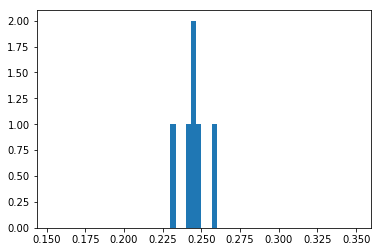

In [57]:
plt.hist(cen_freqs1, bins=freq2[(freq2>0.15)*(freq2<0.35)])